Loading crops...:   0%|          | 0/1315 [00:00<?, ?it/s]

torch.Size([1, 128, 128])
torch.bool


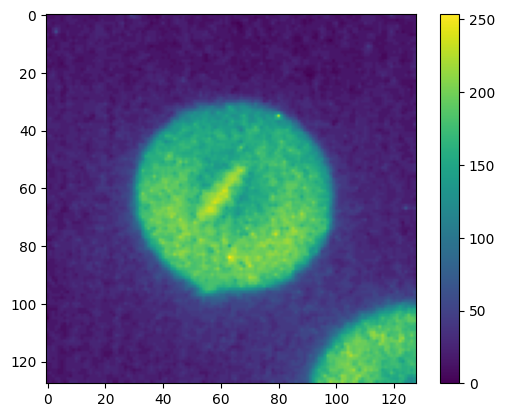

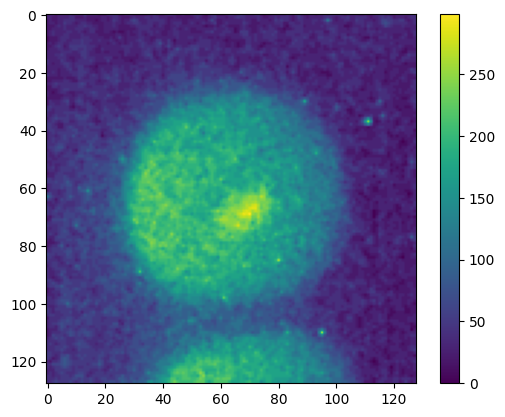

torch.Size([490])
torch.Size([730])
0.5
0.4780821917808219


In [11]:
from models import CPFeatures
from dataset import CellCrops
from pathlib import Path
from transforms import add_ellipse_random_placement
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
import torch

import matplotlib.pyplot as plt

DSET_PATH = Path("/data/dataset/fl_dataset/healthy_train/raw")
dset = CellCrops(DSET_PATH, transforms=None, ext=None, load_to_gpu=None, set_size=128, debug=False)

cp = CPFeatures([2, 32, 64, 128, 256], 3, 3, diam_mean=70, pretrained_path="/model/cyto2torch_0")
#outp_ = cp((dset[0] / 255.)[None,].expand(-1,2,-1,-1))[0]
#print(outp_.shape)

img = dset[0]
img, mask = add_ellipse_random_placement(img, (60,70), (60,70), (10,20), (5,10), (0, 1.6))
print(img.shape)
print(mask.dtype)

def subsample(X, m):
    r"""
    Inputs:

        :X: (N_samples, N_features)

        :m: int

    Returns:
        (m, N_features)
    """
    N_samples = X.shape[0]
    sample_idxs = (torch.rand(m) * N_samples).floor().long()

    return X[sample_idxs]

def test_classifier_forward():
    r"""
    """

    def get_good_bad(img_ok, img_prebad):
        r"""
        Ret X,y balanced dataset.
        """

        img_bad, mask_bad = add_ellipse_random_placement(img_prebad, (60,70), (60,70), (10,15), (5,10), (0, 1.6),
                                                        scale=100.)
        feats_bad = cp((img_bad / img_bad.max())[None,].expand(-1,2,-1,-1))[0][:,mask_bad].T
        feats_ok = subsample(
                cp((img_ok / img_ok.max())[None,].expand(-1,2,-1,-1))[0].flatten(start_dim=1).T,
                feats_bad.shape[0]
            )
        
        plt.imshow(img_bad[0]); plt.colorbar(); plt.show()

        X = torch.cat([feats_ok, feats_bad], dim=0)
        y = torch.cat([torch.zeros(feats_ok.shape[0]),
                             torch.ones(feats_bad.shape[0])
                             ]).int()

        return X, y

    img_ok = dset[0]
    img_prebad = dset[1]
    X_train, y_train = get_good_bad(img_ok, img_prebad)
    
    img_ok_test = dset[2]
    img_prebad_test = dset[3]
    X_test, y_test = get_good_bad(img_ok_test, img_prebad_test)
    print(y_train.shape)
    print(y_test.shape)

    gp_clf = GaussianProcessClassifier()
    gp_clf.fit(X_train, y_train)
    print(gp_clf.score(X_test, y_test))
    
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)
    print(rf_clf.score(X_test, y_test))

test_classifier_forward()
